 # Fiber photometry preprocessing

 + some general pipeline functions

     + bleach correction models

 + quality metrics

In [27]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

import iblphotometry.preprocessing
import iblphotometry.plots

import pynapple as nap

from utils import * # don't 

from one.api import ONE

one = ONE(base_url="https://alyx.internationalbrainlab.org")


In [28]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 166

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# select and load dataset
eid = "974a8a32-2156-4250-b9db-4298fc8daa65"
data_path = Path("/home/georg/data_local/raw_photometry_NE.pqt")
trials = one.load_dataset(eid, "alf/task_00/_ibl_trials.table.pqt")

# load trial data
raw_photometry = pd.read_parquet(data_path)
raw_photometry = nap.TsdFrame(raw_photometry.set_index("times"))

# restricting the fluorescence data to the time within the task +-1s
t_start = trials.iloc[0]["intervals_0"] - 1
t_stop = trials.iloc[-1]["intervals_1"] + 1
session_interval = nap.IntervalSet(t_start, t_stop)
raw_photometry = raw_photometry.restrict(session_interval)


{'r_sq': 0.9062994760779263, 'll': 1754190.892621882, 'aic': -22.755036557460176}
{'r_sq': 0.921180775335886, 'll': 1767569.1958776389, 'aic': -18.770231649995914}


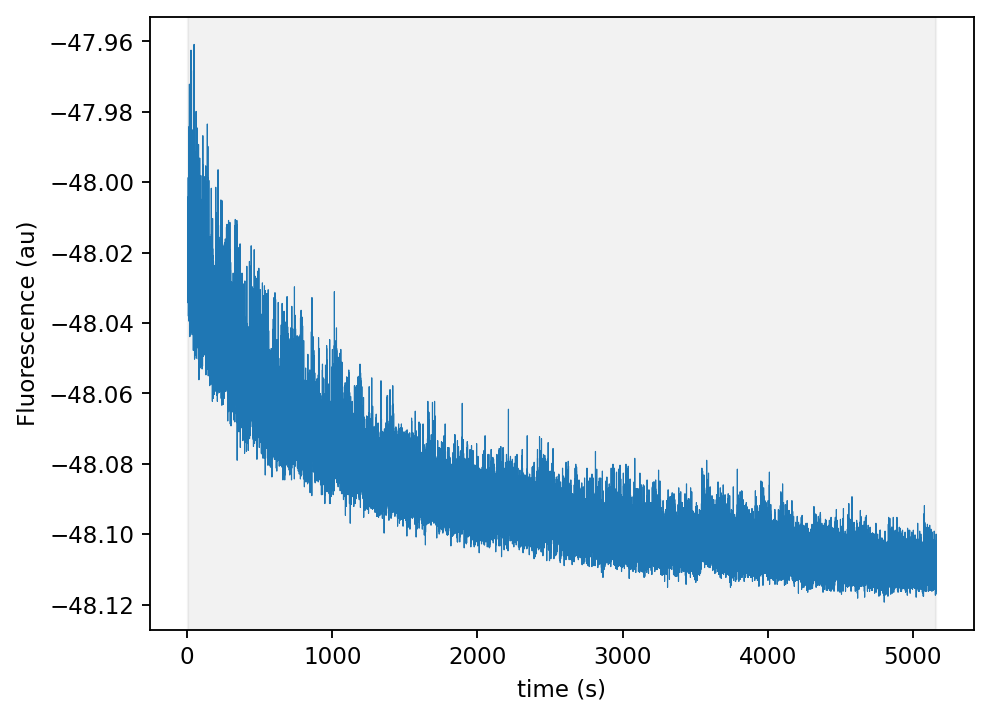

In [30]:
# plot an entire session overview
fig, axes = plt.subplots()
axes.plot(20*np.log10(raw_photometry["raw_calcium"]), lw=0.5)
axes.axvspan(*session_interval.values[0], alpha=0.1, color="gray")
axes.set_xlabel("time (s)")
axes.set_ylabel("Fluorescence (au)")
# axes.set_ylim(*np.percentile(raw_photometry["raw_calcium"].values, (0.01, 99.99)))

F = raw_photometry['raw_calcium']
y, t = F.values, F.times()

from bleach_corrections import ExponDecayBleachingModel, DoubleExponDecayBleachingModel

bleaching_model = ExponDecayBleachingModel()
_ = bleaching_model.bleach_correct(F)
print(bleaching_model.calc_model_stats(F, use_kde=False, n_samples=-1))

bleaching_model = DoubleExponDecayBleachingModel()
_ = bleaching_model.bleach_correct(F)
print(bleaching_model.calc_model_stats(F, use_kde=False, n_samples=-1))



In [31]:
# starting to look at pipelines
from metrics import eval_pipeline
pipeline_evals = {}

In [32]:
# no processing
F_ca = raw_photometry['raw_calcium']
F_iso = raw_photometry['raw_isosbestic']
pipeline_evals['no-proc-ca_z'] = eval_pipeline(F_ca)
pipeline_evals['no-proc-iso_z'] = eval_pipeline(F_iso)

In [33]:
pipeline_evals
# pipeline_evals['no-proc-ca_z'] = eval_pipeline(F_ca)
# number_unique_samples(F.values, {})

{'no-proc-ca_z': {'percentile_dist': {'value': 3.558056769001672,
   'rval': -0.7698033993449181,
   'pval': 0.0007891797252469489},
  'signal_asymmetry': {'value': 1.7790283845061359,
   'rval': -0.5111573798784643,
   'pval': 0.05148867230143799},
  'number_unique_samples': {'value': 498, 'rval': nan, 'pval': nan},
  'number_of_outliers': {'value': 41, 'rval': nan, 'pval': nan}},
 'no-proc-iso_z': {'percentile_dist': {'value': 2.9019659079739393,
   'rval': -0.208433542212111,
   'pval': 0.4559854468700455},
  'signal_asymmetry': {'value': 1.3461114783485157,
   'rval': -0.22918926600975217,
   'pval': 0.4112692456257516},
  'number_unique_samples': {'value': 5861, 'rval': nan, 'pval': nan},
  'number_of_outliers': {'value': 86, 'rval': nan, 'pval': nan}}}

In [34]:
from utils import zscore
# removing bleaching in the logspace
F = raw_photometry['raw_calcium']
BleachingModel = ExponDecayBleachingModel()
F = 20*np.log10(F)
F_corr = BleachingModel.bleach_correct(F)
F_corr = 10**(F_corr/20)
pipeline_evals['sebc-in-log_z'] = eval_pipeline(zscore(F_corr))

# fig, axes = plt.subplots()
# axes.plot(F_corr, lw=0.5)
F = raw_photometry['raw_calcium']
BleachingModel = DoubleExponDecayBleachingModel()
F = 20*np.log10(F)
F_corr = BleachingModel.bleach_correct(F)
F_corr = 10**(F_corr/20)
pipeline_evals['debc-in-log_z'] = eval_pipeline(zscore(F_corr))


/home/georg/code/ibl-photometry/src/iblphotometry/bleach_corrections.py:163: RuntimeWarning: divide by zero encountered in divide
  return A1 * np.exp(-t / tau1) + A2 * np.exp(-t / tau2) + b


In [35]:
# import metrics
# # axes.plot(sliding_z(F_corr,2000),lw=.5)
# # look at signal asymmetry as a function of window size
# w_sizes = np.linspace(50, 1000, 20, dtype='int64')
# asym = []
# for w in w_sizes:
#     a = metrics.signal_asymmetry(sliding_z(F_corr, w))
#     asym.append(a)
    
# fig, axes = plt.subplots()
# axes.plot(w_sizes, asym)    

In [36]:
from bleach_corrections import IsosbesticCorrection

# different isosbestic variants
F_ca = raw_photometry["raw_calcium"]
F_iso = raw_photometry["raw_isosbestic"]

for correction in ['subtract','divide','deltaF']:
    for regressor in ['linear','RANSAC']:
        isosbestic_corrector = IsosbesticCorrection(correction=correction, regressor=regressor)
        F_corr = isosbestic_corrector.correct(F_ca, F_iso)
        pipeline_evals[f'iso-{correction}-{regressor}_z'] = eval_pipeline(zscore(F_corr))
        
# F_corr = isosbestic_correct(F_ca, F_iso, correction='subtract', regressor='linear')
# fig, axes = plt.subplots()
# axes.plot(F_corr)

In [43]:
# oliviers isosbestic
from iblphotometry.preprocessing import isosbestic_regression

F_ca = raw_photometry["raw_calcium"]
F_iso = raw_photometry["raw_isosbestic"]

fs = 1/np.median(np.diff(F_ca.times()))
F_corr = isosbestic_regression(F_iso, F_ca, fs)
pipeline_evals['ibl-iso_z'] = eval_pipeline(zscore(F_corr))

TypeError: operand type(s) all returned NotImplemented from __array_ufunc__(<ufunc 'subtract'>, '__call__', Time (s)
--------------  ----------
3.635966979     0.00397687
3.66927832      0.0039671
3.702621661     0.00396951
3.735965001     0.00397281
3.769276343     0.00397103
3.802619683     0.00396723
3.835931025     0.003969
...
5160.147930698  0.00393235
5160.181274038  0.00393387
5160.21458538   0.00393336
5160.247928721  0.00393374
5160.281272061  0.00393552
5160.314583403  0.00393412
5160.347926743  0.00393159
dtype: float64, shape: (154710,), Time (s)
--------------  ----------
3.635966979     0.00396707
3.66927832      0.00396705
3.702621661     0.00396702
3.735965001     0.003967
3.769276343     0.00396698
3.802619683     0.00396696
3.835931025     0.00396694
...
5160.147930698  0.003929
5160.181274038  0.003929
5160.21458538   0.003929
5160.247928721  0.003929
5160.281272061  0.003929
5160.314583403  0.003929
5160.347926743  0.003929
dtype: float64, shape: (154710,)): 'Tsd', 'Tsd'

In [11]:
# oliviers sliding mad
F_ca = raw_photometry["raw_calcium"]

fs = 1/np.average(np.diff(F_ca.times()))
F_corr = iblphotometry.preprocessing.preprocess_sliding_mad(F_ca.values, F_ca.times(), fs)
F_corr = nap.Tsd(t=F_ca.times(), d=F_corr)

pipeline_evals['ibl-sliding-mad_z'] = eval_pipeline(zscore(F_corr))


In [12]:
# only sliding z
F_ca = raw_photometry.restrict(session_interval)["raw_calcium"]
pipeline_evals['sliding-z'] = eval_pipeline(sliding_z(F_ca, 1000))

In [13]:
from pipelines import sliding_z
# isosbestic correction, deltaF, followed by sliding window z correction
F_corr = isosbestic_correct(F_ca, F_iso, correction='deltaF', regressor='linear')
F_corr = sliding_z(F_corr, 1000)
pipeline_evals['iso-deltaF-linear_sliding-z'] = eval_pipeline(F_corr)

In [14]:
# logspace bleachcorr plus sliding-z
F = raw_photometry['raw_calcium']
BleachingModel = DoubleExponDecayBleachingModel()
F = 20*np.log10(F)
F_corr = BleachingModel.bleach_correct(F)
F_corr = 10**(F_corr/20)
F_corr = sliding_z(F_corr, 1000)
pipeline_evals['debc-in-log_sliding-z'] = eval_pipeline(F_corr)


/home/georg/code/ibl-photometry/src/iblphotometry/bleach_corrections.py:146: RuntimeWarning: divide by zero encountered in divide
  def model(self, t, A1, tau1, A2, tau2, b):


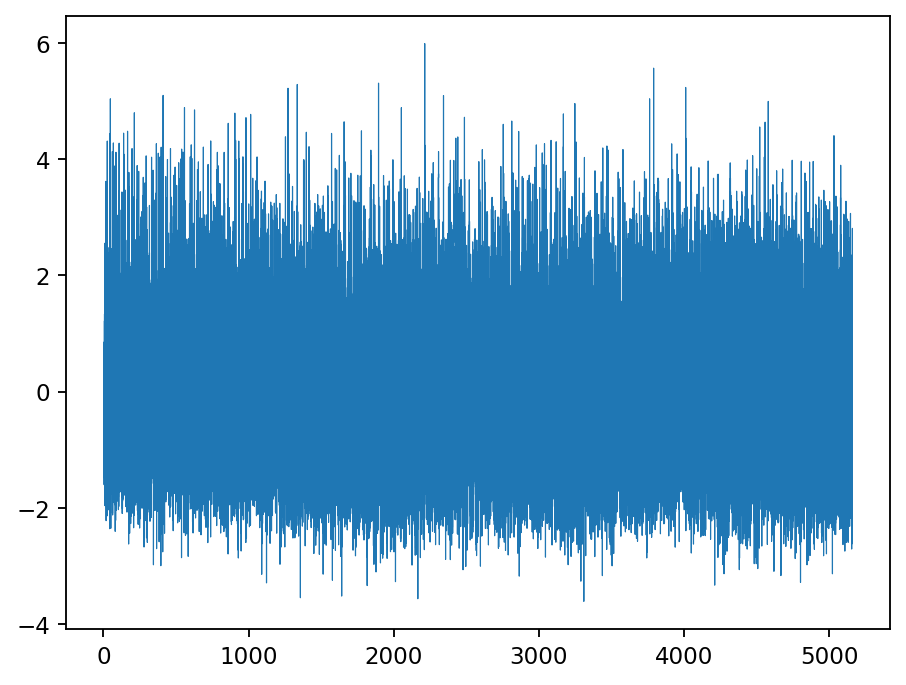

In [15]:
fig, axes = plt.subplots()
axes.plot(F_corr,lw=0.5)

                      name                 metric sub_metric      value
0             no-proc-ca_z        percentile_dist      value   3.558057
1             no-proc-ca_z        percentile_dist       rval  -0.769803
2             no-proc-ca_z        percentile_dist       pval   0.000789
3             no-proc-ca_z       signal_asymmetry      value   1.779028
4             no-proc-ca_z       signal_asymmetry       rval  -0.511157
..                     ...                    ...        ...        ...
175  debc-in-log_sliding-z  number_unique_samples       rval        NaN
176  debc-in-log_sliding-z  number_unique_samples       pval        NaN
177  debc-in-log_sliding-z     number_of_outliers      value  34.000000
178  debc-in-log_sliding-z     number_of_outliers       rval        NaN
179  debc-in-log_sliding-z     number_of_outliers       pval        NaN

[180 rows x 4 columns]
                            name           metric sub_metric     value
0                   no-proc-ca_z  percent

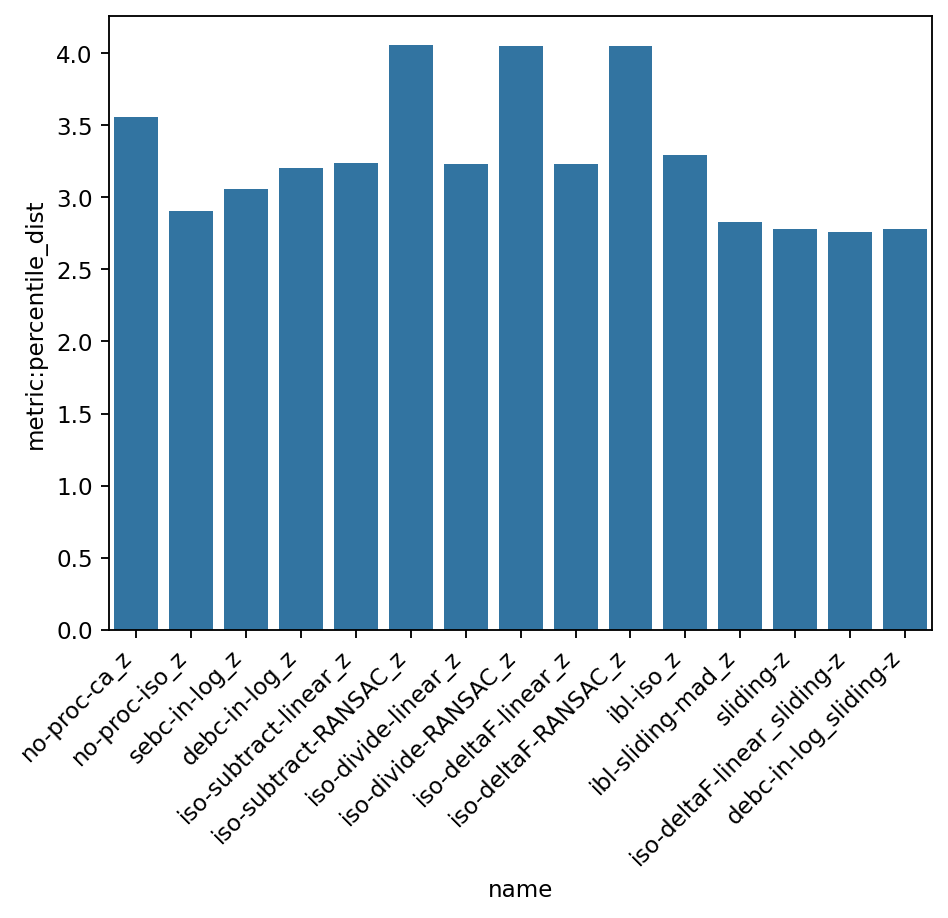

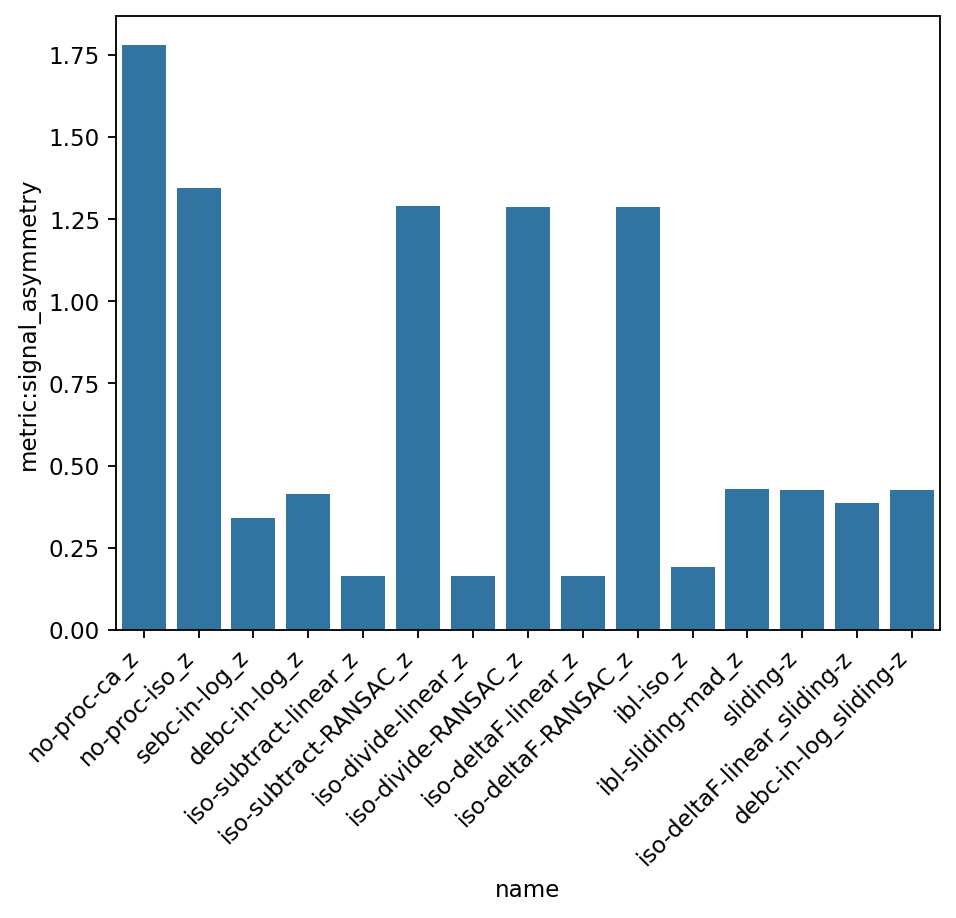

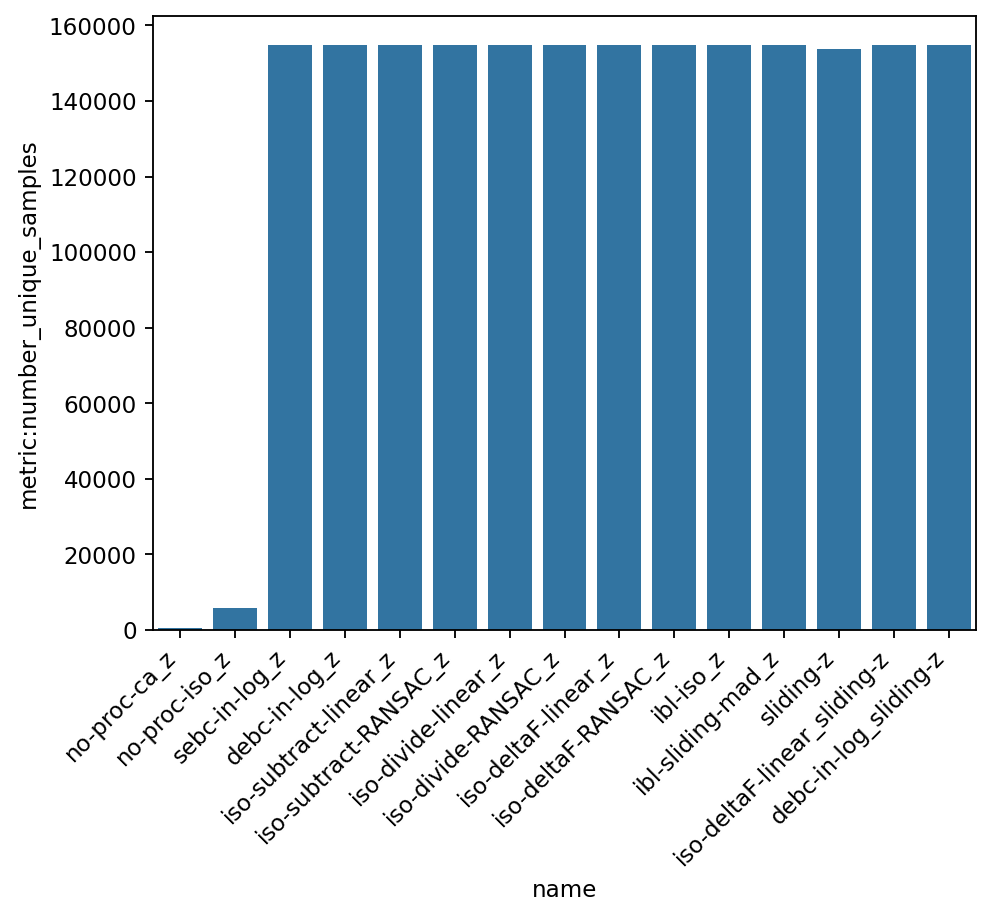

In [17]:
import seaborn as sns

def pipline_eval_to_df(pipeline_evals: dict):
    keys = []
    values = []
    for key, value in pipeline_evals.items():
        for key_, value_ in value.items():
            for key__, value__ in value_.items():
                keys.append((key, key_, key__))
                values.append(value__)

    df = pd.DataFrame(dict(zip(keys, [(val,) for val in values])))
    df = df.melt()
    df.columns = ["name", "metric", "sub_metric", "value"]
    return df


df = pipline_eval_to_df(pipeline_evals)
print(df)
for metric in ["percentile_dist", "signal_asymmetry",'number_unique_samples']:
    df_ = df.groupby(["metric", "sub_metric"]).get_group((metric, "value"))
    print(df_)
    fig, axes = plt.subplots()
    axes = sns.barplot(df_, x="name", y="value", axes=axes)
    axes.set_xticks(axes.get_xticks(), axes.get_xticklabels(), rotation=45, ha="right")
    axes.set_ylabel(f"metric:{metric}")

In [ ]:
correction = 'deltaF'
regressor = 'RANSAC'
F_corr = isosbestic_correct(F_ca, F_iso, correction=correction, regressor=regressor)
fig, axes = plt.subplots()
axes.plot(F_corr, lw=0.5)

correction = 'deltaF'
regressor = 'linear'
F_corr = isosbestic_correct(F_ca, F_iso, correction=correction, regressor=regressor)
axes.plot(F_corr, lw=0.5)

In [52]:
from iblphotometry.preprocessing import psth

F_ = filt(zscore(F_corr),3,5)
y, t = F_.values, F_.times()

reward_times = trials.loc[trials['feedbackType'] == 1]['feedback_times'].values
movement_times = trials.loc[trials['feedbackType'] == 1]['firstMovement_times'].values
align_times = movement_times
psth_data, psth_inds = psth(y, t, align_times)


In [74]:
t_psth = t[psth_inds[:,0]] - align_times[0]
# psth_t = t[psth_inds[0]]- align_times[0]
plt.figure()
plt.plot(t_psth, np.nanmean(psth_data, axis=1))
plt.fill_between(t_psth, *np.nanpercentile(psth_data, (5,95), axis=1), alpha=0.2)



In [37]:
# ROBUST regression using least_squares
from scipy.optimize import least_squares

F_ca = raw_photometry["raw_calcium"]
F_iso = raw_photometry["raw_isosbestic"]
t = F_ca.times()


def lin(x, m, b):
    return x * m + b


def obj_fun(p, y1, y2):
    y2_hat = lin(y2, *p)
    return np.sum((y1 - y2_hat) ** 2)


p0 = [1, 1]

minimize_result = least_squares(
                obj_fun,
                p0,
                args=(F_ca.values, F_iso.values),
)

from scipy.optimize import minimize
minimize_result = minimize(
    obj_fun,
    p0,
    args=(F_ca.values, F_iso.values),
    method='SLSQP'
)

popt = minimize_result.x
fig, axes = plt.subplots()
axes.plot(t, F_ca.values)
axes.plot(t, lin(F_iso.values, *popt))

## steps to do
- inject random noise spikes (of random lenght)
- check what 

In [ ]:

dtype = np.dtype((np.float64, w_size))
B = np.fromiter(wg.slice_array(Y), dtype=dtype)
# B = np.pad(B, ((int(w_size / 2), int(w_size / 2)), (0, 0)), mode="edge")
    # return B

In [ ]:
# %%
# histogram plot
from scipy.stats import skew
def histogram_eval_plot(F, axes=None, hist_kwargs=None):
    if axes is None:
        fig, axes = plt.subplots()
    bins = np.linspace(-4,4,200)
    axes.hist(zscore(F_ca_corr).values, bins=bins, **hist_kwargs)
    # axes.set_title(f'skew={skew(zscore(F_ca_corr).values)}')
    axes.axvline(0, linestyle=':', color='k', lw=1)
    return axes

# %%
# quantile evaluation plot
def quantile_eval_plot(F, axes=None, plot_kwargs=None):
    if axes is not None:
        fig, axes = plt.subplots()
    ps = np.linspace(1,99,50)
    zs = np.percentile(zscore(F).values, ps)
    axes.plot(ps, zs, **plot_kwargs)
    # axes.axhline(0, linestyle=':', color='k', lw=1)
    # axes.axvline(50, linestyle=':', color='k', lw=1)
    return axes